#**Zaid Parvej Patel** (zp2090)
### **MMDS-HW3 - Locality Sensitivity Hashing** - Spring 2022
###Date of Submission : 02/28/2022

# **Q.1: LSH Evaluation (20 points)**

Pr(r= 3 & b= 10 ) =  [0.009955119790251765, 0.07718058804273675, 0.23944889319887064, 0.4838707317677322, 0.7369244238361716, 0.9122674753991765, 0.985015105295655, 0.9992340538808936, 0.9999978635491371]


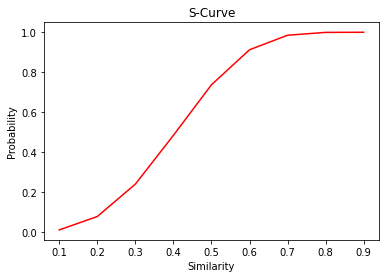



Pr(r= 6 & b= 20 ) =  [1.9999810001669616e-05, 0.001279222058761964, 0.014479466504172311, 0.07880932311056232, 0.27018714400947597, 0.6154146360312677, 0.9181859965846744, 0.9977121251546806, 0.9999997398129465]


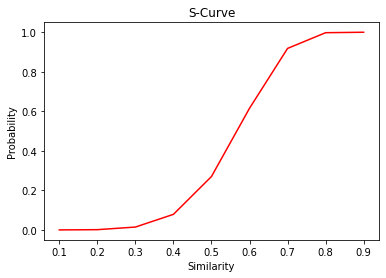



Pr(r= 5 & b= 50 ) =  [0.0004998775195954597, 0.01587519984502117, 0.11453988231042189, 0.4022839522088044, 0.7955506304323648, 0.9825338277068608, 0.9998989958361557, 0.9999999976077777, 1.0]


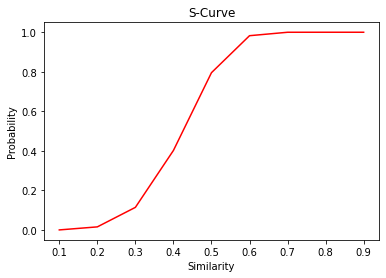

In [1]:
#Plotting the S-curve:

import numpy as np
import matplotlib.pyplot as plt

R = [3,6,5]
B = [10,20,50]

S = np.arange(0.1,1,0.1)
for r,b in zip(R,B):
  Pr = []
  for s in S:
    p = 1 - (1-(s)**r)**b
    Pr.append(p)
  print("Pr(r=",r,"& b=",b,") = ",Pr)

  plt.title("S-Curve")
  plt.xlabel("Similarity")
  plt.ylabel("Probability")
  plt.plot(S, Pr, color ="r")
  plt.show()
  print("\n")

# **Q2: LSH for approximate Near Neighbor Search (30 points)**

In [19]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/MMDS/patches.csv")
df

,5.200000000000000000e+01,6.500000000000000000e+01,8.100000000000000000e+01,6.700000000000000000e+01,7.000000000000000000e+01,4.900000000000000000e+01,4.800000000000000000e+01,7.700000000000000000e+01,1.020000000000000000e+02,9.500000000000000000e+01,7.000000000000000000e+01.1,5.300000000000000000e+01,8.100000000000000000e+01.1,5.700000000000000000e+01,9.000000000000000000e+00,1.000000000000000000e+00,1.000000000000000000e+00.1,1.000000000000000000e+00.2,1.900000000000000000e+01,3.300000000000000000e+01,7.400000000000000000e+01,8.500000000000000000e+01,9.700000000000000000e+01,7.700000000000000000e+01.1,5.300000000000000000e+01.1,6.900000000000000000e+01,9.200000000000000000e+01,9.900000000000000000e+01,6.800000000000000000e+01,2.500000000000000000e+01,9.000000000000000000e+00.1,1.800000000000000000e+01,2.400000000000000000e+01,3.100000000000000000e+01,4.000000000000000000e+00,4.000000000000000000e+00.1,1.400000000000000000e+01,1.000000000000000000e+00.3,1.900000000000000000e+01.1,6.900000000000000000e+01.1,...,3.100000000000000000e+01.4,4.000000000000000000e+01.2,1.900000000000000000e+01.6,1.000000000000000000e+00.16,0.000000000000000000e+00.11,7.000000000000000000e+00.3,3.000000000000000000e+00.5,1.400000000000000000e+01.6,4.200000000000000000e+01.3,3.500000000000000000e+01.2,1.300000000000000000e+01.7,1.600000000000000000e+01.4,5.100000000000000000e+01.1,6.400000000000000000e+01.2,4.200000000000000000e+01.4,1.000000000000000000e+00.17,1.400000000000000000e+01.7,9.000000000000000000e+01.1,1.630000000000000000e+02,1.920000000000000000e+02,1.400000000000000000e+01.8,2.700000000000000000e+01.6,2.300000000000000000e+01.4,1.400000000000000000e+01.9,1.300000000000000000e+01.8,0.000000000000000000e+00.12,0.000000000000000000e+00.13,1.900000000000000000e+01.7,4.200000000000000000e+01.5,3.100000000000000000e+01.5,2.100000000000000000e+01.8,3.800000000000000000e+01.2,5.500000000000000000e+01.5,6.000000000000000000e+01.1,4.100000000000000000e+01.2,3.000000000000000000e+00.6,1.200000000000000000e+01.2,9.700000000000000000e+01.1,1.830000000000000000e+02,2.130000000000000000e+02
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,254.0,255.0,253.0,244.0,211.0,171.0,145.0,135.0,137.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,254.0,255.0,253.0,244.0,211.0,171.0,145.0,135.0,137.0,...,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,254.0,255.0,253.0,244.0,211.0,171.0,145.0,135.0,137.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,254.0,255.0,253.0,244.0,211.0,171.0,145.0,135.0,137.0
1,20.0,5.0,3.0,10.0,17.0,34.0,51.0,53.0,44.0,40.0,44.0,74.0,72.0,100.0,122.0,120.0,136.0,152.0,140.0,121.0,9.0,3.0,1.0,1.0,5.0,15.0,27.0,36.0,40.0,54.0,77.0,108.0,122.0,132.0,136.0,142.0,146.0,132.0,113.0,110.0,...,26.0,8.0,0.0,1.0,29.0,65.0,58.0,10.0,16.0,79.0,111.0,121.0,154.0,187.0,205.0,201.0,167.0,131.0,120.0,91.0,8.0,0.0,0.0,3.0,12.0,23.0,38.0,86.0,93.0,60.0,82.0,130.0,129.0,148.0,187.0,199.0,160.0,115.0,101.0,84.0
2,5.0,82.0,153.0,204.0,206.0,116.0,33.0,34.0,67.0,79.0,109.0,129.0,111.0,94.0,95.0,82.0,109.0,106.0,36.0,5.0,1.0,69.0,148.0,204.0,201.0,106.0,32.0,48.0,68.0,70.0,103.0,155.0,149.0,117.0,115.0,107.0,124.0,100.0,29.0,3.0,...,44.0,103.0,164.0,211.0,201.0,103.0,30.0,43.0,72.0,86.0,90.0,119.0,133.0,106.0,97.0,102.0,66.0,29.0,0.0,0.0,43.0,102.0,163.0,210.0,200.0,103.0,30.0,43.0,65.0,76.0,95.0,114.0,90.0,59.0,56.0,41.0,23.0,3.0,0.0,2.0
3,105.0,108.0,108.0,108.0,112.0,118.0,129.0,113.0,113.0,136.0,127.0,112.0,124.0,116.0,61.0,53.0,41.0,64.0,156.0,196.0,106.0,110.0,110.0,109.0,112.0,118.0,130.0,115.0,115.0,137.0,127.0,113.0,126.0,120.0,63.0,65.0,46.0,50.0,141.0,197.0,...,93.0,82.0,68.0,52.0,33.0,16.0,26.0,79.0,141.0,176.0,186.0,194.0,210.0,224.0,173.0,63.0,0.0,0.0,14.0,45.0,76.0,62.0,30.0,8.0,23.0,52.0,133.0,163.0,179.0,184.0,209.0,227.0,183.0,113.0,16.0,0.0,1.0,13.0,35.0,74.0
4,84.0,100.0,118.0,88.0,43.0,31.0,36.0,87.0,168.0,201.0,214.0,139.0,35.0,28.0,44.0,46.0,44.0,48.0,43.0,4

In [39]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla

import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import itertools
from collections import OrderedDict
from statistics import mean

In [5]:
# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
  dist = np.linalg.norm(u-v)
  return dist

In [6]:
# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data():
  filename = '/content/drive/MyDrive/MMDS/patches.csv'
  return np.genfromtxt(filename, delimiter=',')
A = load_data()

In [8]:
# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

In [9]:
# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

In [10]:
# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])


In [11]:
# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [12]:
# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [13]:
# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k, L):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)
functions,hashed_A = lsh_setup(A,24, 10)

In [14]:
# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    return [t[0] for t in best_neighbors]

In [23]:
# Finds the nearest neighbors to a given vector, using linear search.

def linear_search(A,query_index,num_neighbors):
    distances = {}
    for i in range(len(A)):
        if query_index == i:
            continue
        else:
            distance = l1(A[i],A[query_index])
            distances.update({i:distance})
    sorted_distances = OrderedDict(sorted(distances.items(), key=lambda x: x[1]))
    return dict(itertools.islice(sorted_distances.items(), num_neighbors))

# 1) Average Search time for LSH and Linear Search.

In [41]:
query_indices = [100,200,300,400,500,600,700,800,900,1000]
lshresults = []
lsresults = {}
endtimelsh = []
endtimels = []
for i in query_indices:
    start_time_lsh = time.time()
    lsh_search_result = lsh_search(A,hashed_A,functions,i,10)
    end_time_lsh = time.time()
    time_elapsed_lsh = (end_time_lsh - start_time_lsh)
    endtimelsh.append(time_elapsed_lsh)
    lshresults.append(lsh_search_result)
    start_time_ls = time.time()
    linear_search_result = linear_search(A,i,10)
    end_time_ls = time.time()
    time_elapsed_ls = (end_time_ls - start_time_ls)
    endtimels.append(time_elapsed_ls)
    lsresults.update({i:linear_search_result})
    print("LSH",lsh_search_result)
    print(time_elapsed_lsh)
    print("--------------------------------------------------------")
    print("Linear Search",linear_search_result)
    print(time_elapsed_ls,"\n")
print("\n\n")
print("The average runtime for LSH Search : ", mean(endtimelsh))
print("The average runtime for Linear Search : ", mean(endtimels))

LSH [8196, 28351, 21780, 14383, 37765, 24374, 18866, 28251, 25289, 10123]
0.5160188674926758
--------------------------------------------------------
Linear Search {8196: 502.3136470373864, 28351: 505.9456492549373, 21780: 517.2774883947686, 14383: 521.3616786838097, 37765: 523.9093433028276, 24374: 524.8466442685901, 18866: 527.2570530585627, 28251: 528.7210985009015, 25289: 531.9389062664998, 10123: 532.4030428162483}
1.045637607574463 

LSH [39581, 3692, 41588, 15314, 3618, 11611, 52134, 51943, 29835, 41416]
0.40863609313964844
--------------------------------------------------------
Linear Search {39581: 750.484510166599, 3692: 758.9993412381858, 41588: 761.4151298733169, 15314: 767.2098800198027, 3618: 768.7808530394082, 1888: 768.8751524142265, 11611: 769.5238787718026, 52134: 771.5996371175922, 51943: 772.1696704740481, 28688: 774.5998967208814}
0.6521399021148682 

LSH [15818, 9006, 8410, 16448, 39158, 17578, 7447, 22509, 22057, 24489]
0.37085413932800293
----------------------

# 2) Plot for error values vs L and error value vs K

In [42]:
# TODO: Write a function that computes the error measure
def lsh_error(hashed_A,functions):
    query_indices = [100,200,300,400,500,600,700,800,900,1000]
    error = 0
    for j in query_indices:
        lsh_dist = 0
        lshSearch = lsh_search(A,hashed_A,functions,j,3)
        #print(lshSearch)
        for x in lshSearch:
            lshDist = l1(A[j],A[x])
            lsh_dist+=lshDist
        linear_dist = 0
        linearSearchDict = linear_search(A,j,3)
        linearSearch = list(linearSearchDict.keys())
        #print(linearSearch)
        for y in linearSearch:
            linearDist = l1(A[j],A[y])
            linear_dist+=linearDist
        error+=(lsh_dist/linear_dist)
    return error/10    

In [34]:
#Calculating the error values when k=24 and L = [10,12,14,16,18,20]

k = 24
L = [10,12,14,16,18,20]
error = []
for i in L:
  functions,hashed_A = lsh_setup(A,k,i)
  err = lsh_error(hashed_A,functions)
  error.append(err)
print(error)

[1.0304682444334918, 1.0185883247979917, 1.019218694334677, 1.0168290510454003, 1.0081102069946115, 1.0130047816917354]


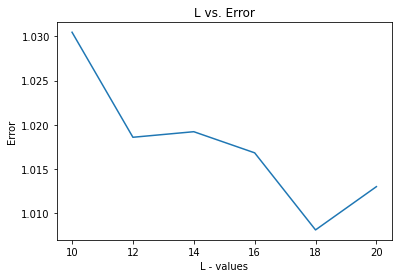

In [36]:
#Plotting the L vs Error graph:

plt.plot(L,error)
plt.xlabel('L - values')
plt.ylabel('Error')
plt.title('L vs. Error')
plt.show()

In [37]:
#Calulating the error values when L = 10 and k = [16,18,20,22,24]

L = 10
k = [16,18,20,22,24]
error = []
for i in k:
  functions,hashed_A = lsh_setup(A,i,L)
  err = lsh_error(hashed_A,functions)
  error.append(err)
print(error)

[1.006151269137267, 1.0036056539769551, 1.0043345631368852, 1.0118738007311785, 1.0361752609999528]


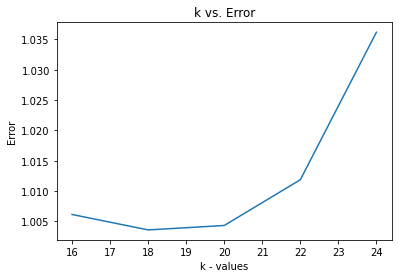

In [38]:
#Plotting the k vs. Error Graph

plt.plot(k,error)
plt.xlabel('k - values')
plt.ylabel('Error')
plt.title('k vs. Error')
plt.show()

# **3) Plot the 10 nearest neighbors found by both methods.**

In [21]:
lsh100 = lshresults[0:1]
print(lsh100)

ls = lsresults.get(100)
ls100 = list(ls.keys())

print(ls100)

[[8196, 28351, 21780, 14383, 37765, 24374, 18866, 28251, 25289, 10123]]
[8196, 28351, 21780, 14383, 37765, 24374, 18866, 28251, 25289, 10123]


In [22]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

In [ ]:
#Retrieving images of 10 nearest neighbors using LSH

plot(A,lsh100[0],"lshpics")

In [ ]:
#Retrieving images of 10 nearest neighbors using Linear Search:

plot(A,ls100,"linear_search_pics")

In [44]:
og = [100]

In [45]:
# Plotting the original image

plot(A,og,"Original_img")